# Identifying sources

`opticam` uses `photutils` to find sources in images. This notebook will demonstrate how to define source finders for use with `opticam`, as well as explain `opticam`'s default behaviour when no source finder is specified.

## Test Image

First thing's first, let's open an image that contains some sources. For this example, I'll use one of the images from the [Basic Usage tutorial](basic_usage.ipynb):

In [1]:
import opticam

opticam.generate_observations(
    out_dir='finders_tutorial/data',
    n_images=3,
    circular_aperture=False,
    )

[OPTICAM] variable source is at (131, 115)
[OPTICAM] variability RMS: 0.02 %
[OPTICAM] variability frequency: 0.135 Hz
[OPTICAM] variability phase lags:
    [OPTICAM] g-band: 0.000 radians
    [OPTICAM] r-band: 1.571 radians
    [OPTICAM] i-band: 3.142 radians


Generating observations: 100%|██████████|[00:00<00:00]


In [2]:
from astropy.io import fits
import numpy as np
import os

files = os.listdir("finders_tutorial/data")
file = files[0]

with fits.open(f"finders_tutorial/data/{file}") as hdul:
    print(repr(hdul[0].header))
    image = np.array(hdul[0].data)
    binning_factor = int(hdul[0].header['BINNING'][0])

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
FILTER  = 'r       '                                                            
BINNING = '4x4     '                                                            
GAIN    =                  1.0                                                  
EXPOSURE=                  1.0                                                  
DARKCURR=                  0.0                                                  
RA      =                  0.0                                                  
DEC     =                  0

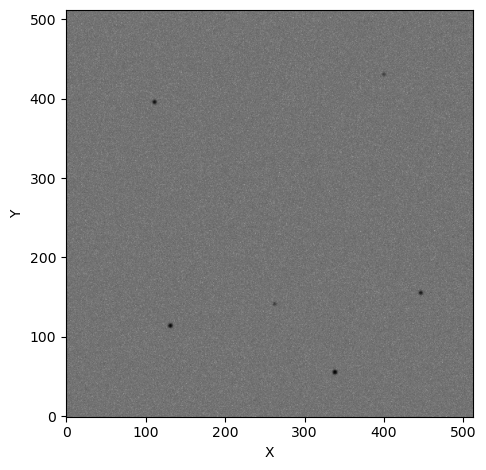

In [3]:
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(
    image,
    norm=simple_norm(image, stretch="log"),
    origin="lower",
    cmap="Greys",
    )

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

## Default Finder

`opticam` implements two default source finders: `Finder` (default) and `CrowdedFinder` (better for crowded fields, but more expensive). `Finder` does not implement any source deblending, while `CrowdedFinder` does. Both of these source finders are wrappers for `photutils.segmentation.SourceFinder` with some added convenience tailored to OPTICAM.

Let's use `opticam.Finder` to identify the sources in the above image:

In [4]:
from opticam import DefaultFinder

from photutils.segmentation import detect_threshold

# default value for npixels is 128 // binning_factor**2
# default value for border_width is 1/16th of the image width
default_finder = DefaultFinder(npixels=128 // 4**2, border_width=image.shape[0] // 16)

default_tbl = default_finder(
    image,
    threshold=detect_threshold(image, nsigma=5),  # 5 sigma detection threshold
    )
print(type(default_tbl))

<class 'astropy.table.table.QTable'>


When calling a `DefaultFinder()` instance, an `astropy.table.QTable` instance is returned that is sorted in descending order of source flux. This is how catalogs are defined in `opticam`. We can use the table to visualise which sources have been identified and how their fluxes are ranked:

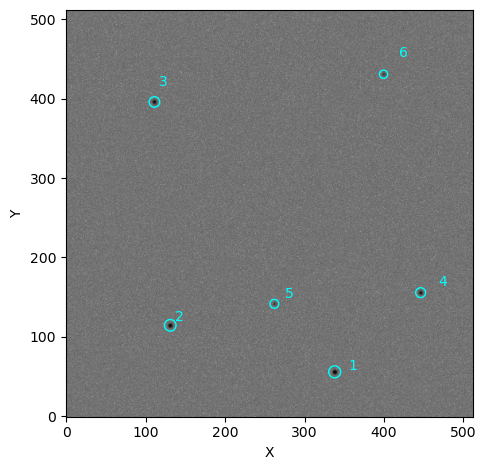

In [5]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(
    tight_layout=True,
    )

im = ax.imshow(
    image,
    norm=simple_norm(image, stretch="log"),
    origin="lower",
    cmap="Greys",
    )

for i, row in enumerate(default_tbl):
    
    xc = row['xcentroid']
    yc = row['ycentroid']
    
    ax.add_patch(
        Circle(
            xy=(xc, yc),
            radius=5 * row['semimajor_sigma'].value,
            facecolor='none',
            edgecolor='cyan',
            lw=1,
        )
    )
    
    ax.text(
        xc * 1.05,
        yc * 1.05,
        f'{i + 1}',
        color='cyan',
    )

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

## Custom Source Finders

### Defining the Source Finder

Let's now define a custom source finder. A custom source finder must be a `callable` that takes two parameters: `image` and `threshold`, and returns a `QTable` instance. `image` should be an `NDArray` containing the image data. `threshold` defines the threshold for source detection in ADU. The simplest way to define a custom source finder is by using the `photutils.segmentation.SourceFinder` class, which combines source detection and deblending:

In [6]:
from photutils.segmentation import SourceCatalog, SourceFinder

def custom_finder(image, threshold):
    finder = SourceFinder(
        npixels=128 // 4**2,  # same as DefaultFinder
        deblend=True,  # same as DefaultFinder
        nlevels=256,  # higher than DefaultFinder (more deblending)
        contrast=0,  # higher than DefaultFinder (more deblending)
        progress_bar=False,  # disable progress bar (same as DefaultFinder)
        )
    segment_img = finder(image, threshold)
    
    tbl = SourceCatalog(image, segment_img).to_table()
    tbl.sort('segment_flux', reverse=True)  # sort in descending order
    
    return tbl

Under-the-hood, `opticam.DefaultFinder` also uses `photutils.segmentation.SourceFinder`, but here we have defined our custom source finder to use different parameter values for better source deblending (though deblending isn't really needed for our example images). In addition to the different parameter values, our custom finder differs from `DefaultFinder` in that `DefaultFinder` automatically omits sources that are close to the edge of an image (where "close" is defined as 1/16th of the image width, the same size as the [default background pixels](backgrounds.ipynb)). For this example, this will not make a difference but it can be important in practise. To understand how to remove sources from a `SegmentationImage` that are too close to an edge, I refer to the excellent `photutils` documentation: https://photutils.readthedocs.io/en/stable/user_guide/segmentation.html.

Let's now initialise this custom source finder and use it to identify sources in the above image.

In [7]:
custom_tbl = custom_finder(
    image,
    threshold=detect_threshold(image, nsigma=5),  # 5 sigma detection threshold
    )

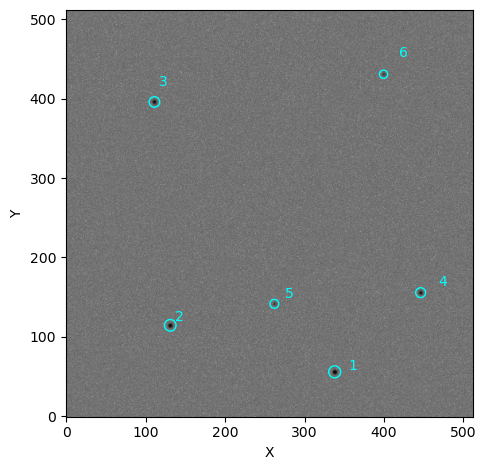

In [8]:
fig, ax = plt.subplots(
    tight_layout=True,
    )

im = ax.imshow(
    image,
    norm=simple_norm(image, stretch="log"),
    origin="lower",
    cmap="Greys",
    )

for i, row in enumerate(custom_tbl):
    
    xc = row['xcentroid']
    yc = row['ycentroid']
    
    ax.add_patch(
        Circle(
            xy=(xc, yc),
            radius=5 * row['semimajor_sigma'].value,
            facecolor='none',
            edgecolor='cyan',
            lw=1,
        )
    )
    
    ax.text(
        xc * 1.05,
        yc * 1.05,
        f'{i + 1}',
        color='cyan',
    )

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

As we can see, we have once again recovered all six sources. Let's now see how to use this custom source finder with `opticam.Reducer`:

[OPTICAM] finders_tutorial/custom_results not found, attempting to create ...
[OPTICAM] finders_tutorial/custom_results created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]


[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 3 g-band images.
[OPTICAM] 3 r-band images.
[OPTICAM] 3 i-band images.


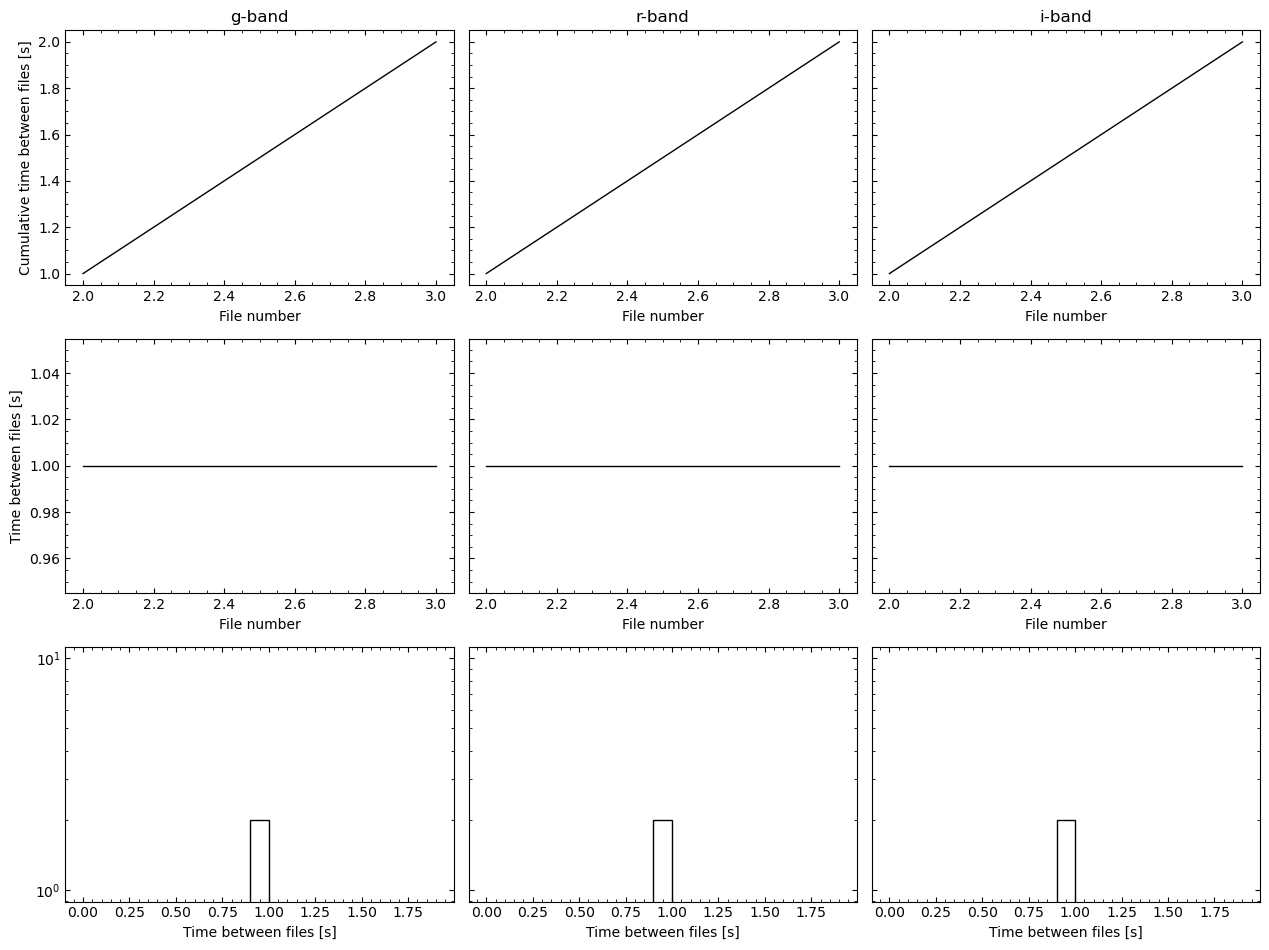

[OPTICAM] Creating source catalogs


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 3 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 3 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 3 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


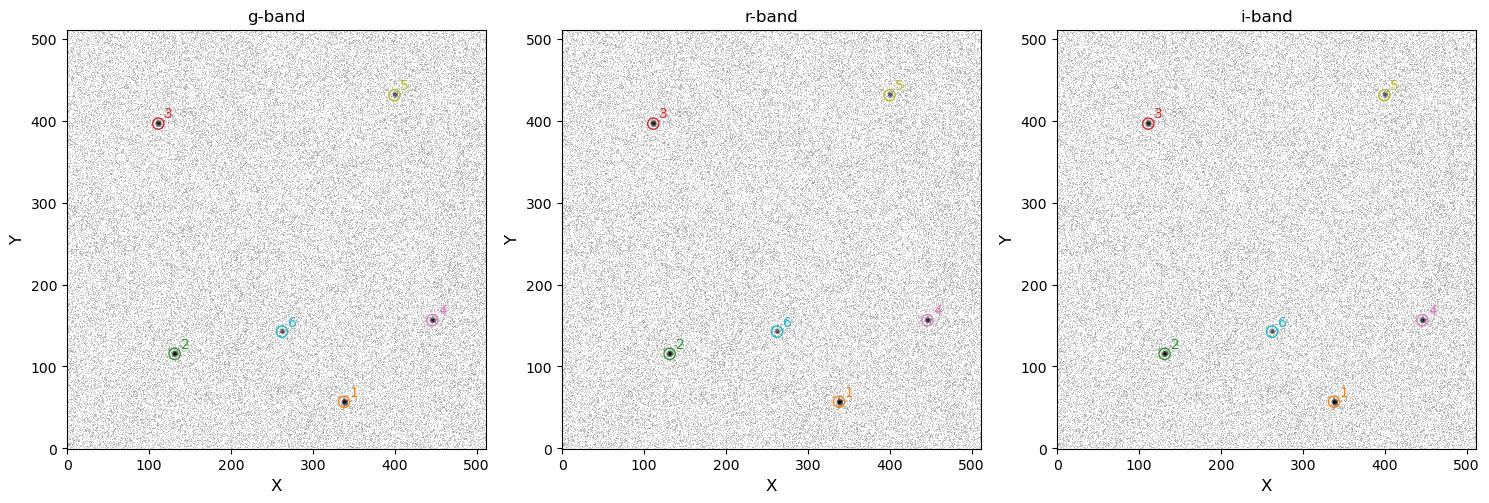

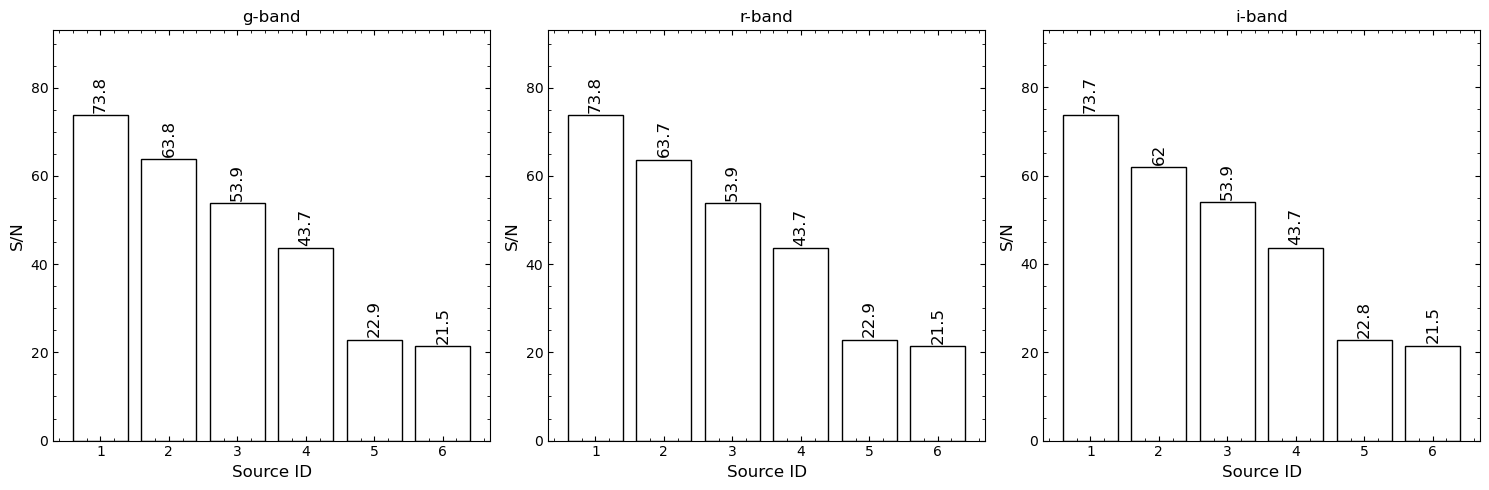

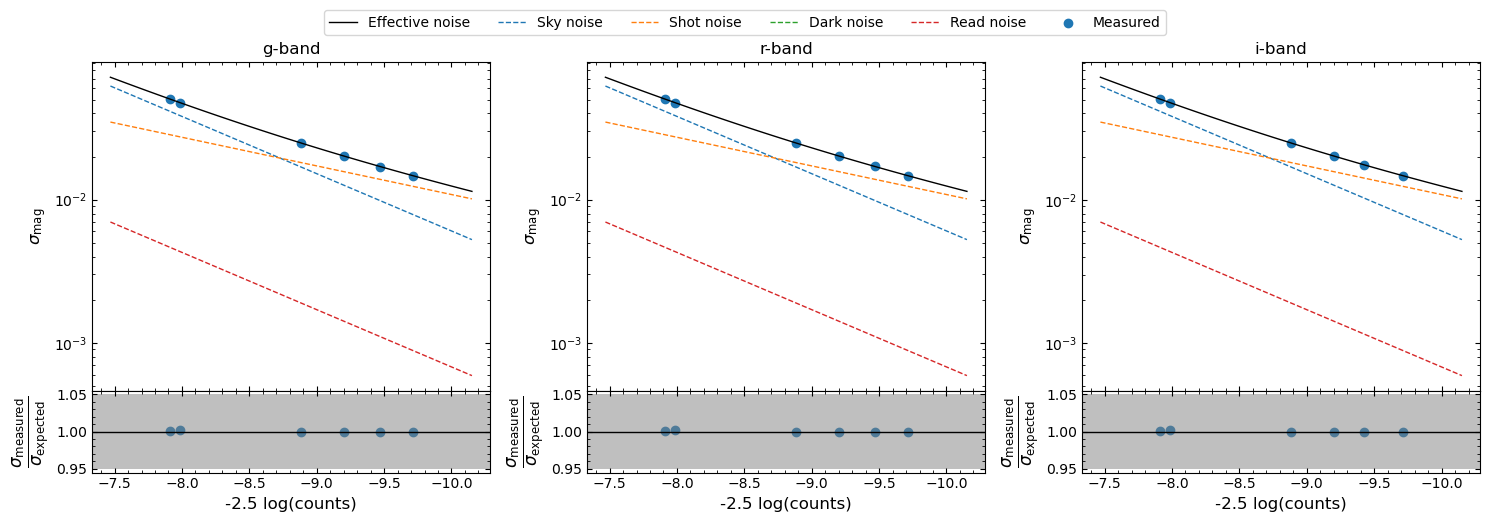

In [9]:
custom_reducer = opticam.Reducer(
    out_directory='finders_tutorial/custom_results',
    data_directory='finders_tutorial/data',
    finder=custom_finder,  # use custom source finder
    remove_cosmic_rays=False,
)

custom_reducer.create_catalogs()

Our custom source finder has been used to successfully identify all six sources. Let's compare this to using `DefaultFinder`:

[OPTICAM] finders_tutorial/default_results not found, attempting to create ...
[OPTICAM] finders_tutorial/default_results created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]


[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 3 g-band images.
[OPTICAM] 3 r-band images.
[OPTICAM] 3 i-band images.


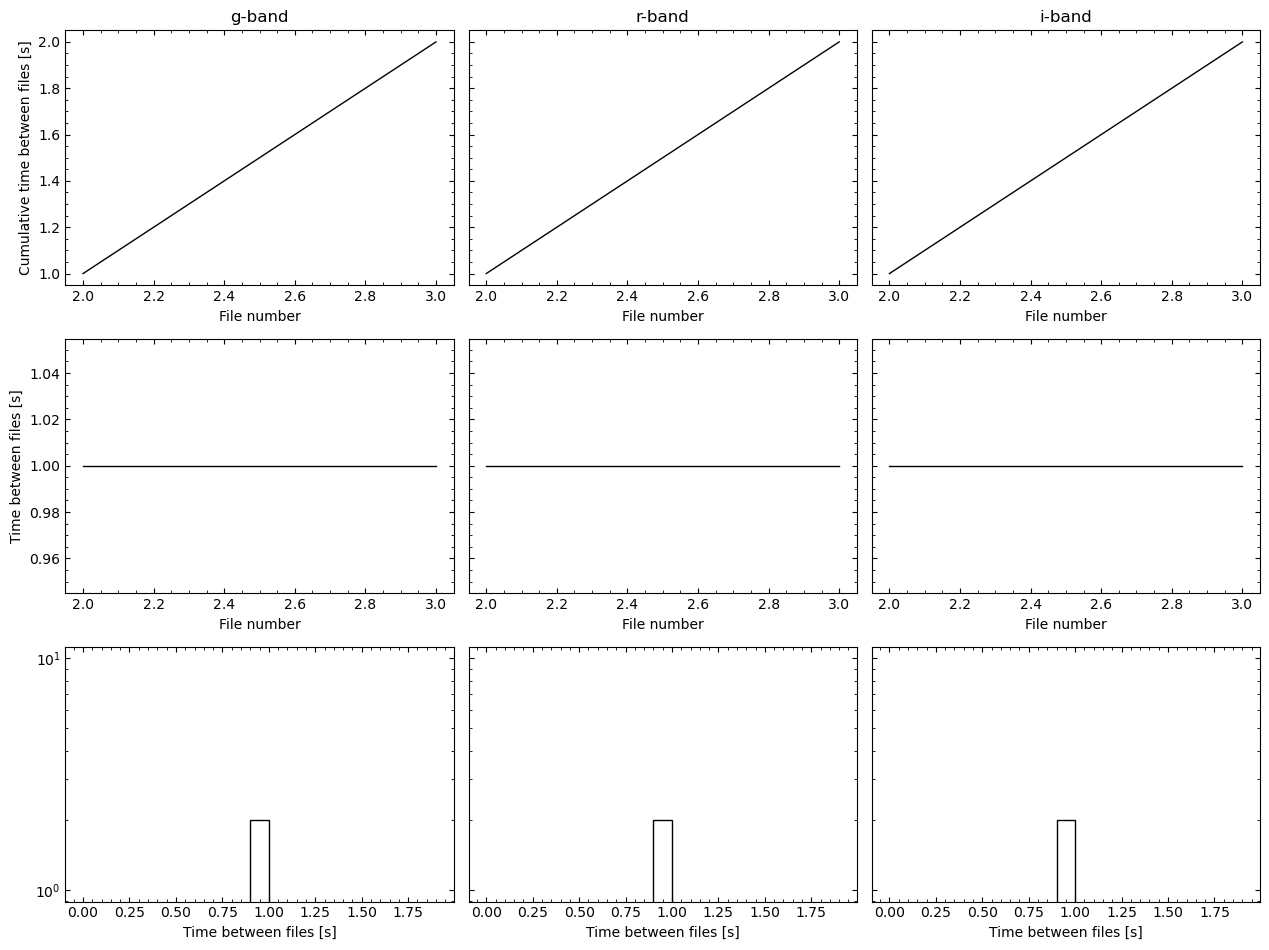

[OPTICAM] Creating source catalogs


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]

[OPTICAM] Done.
[OPTICAM] 3 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.



[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]

[OPTICAM] Done.
[OPTICAM] 3 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.



[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 3 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


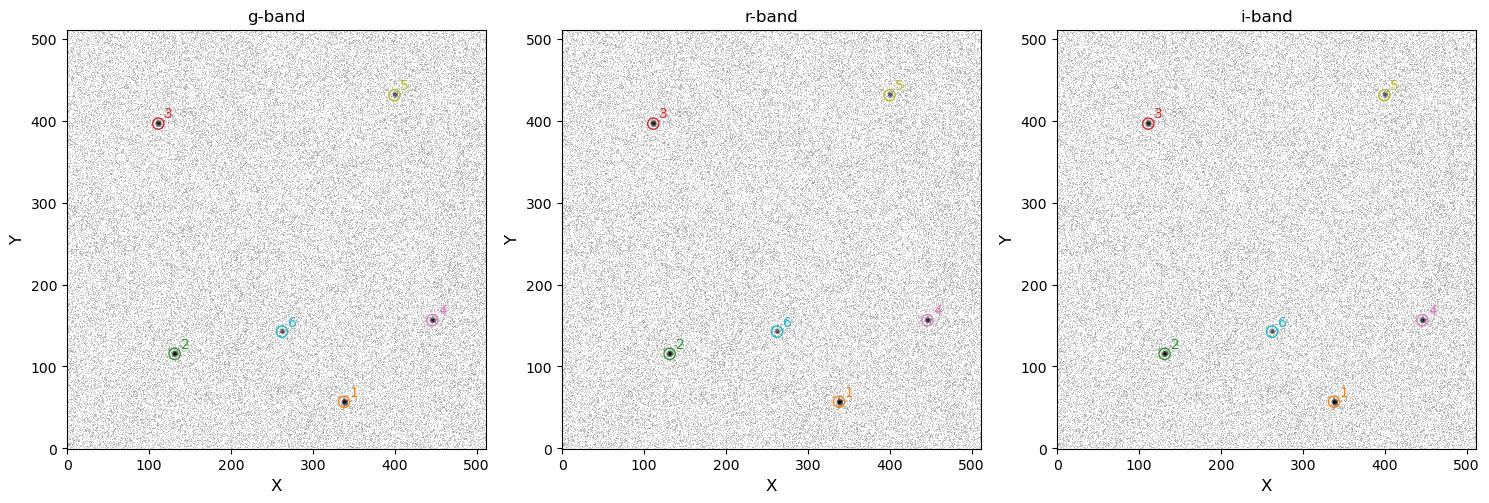

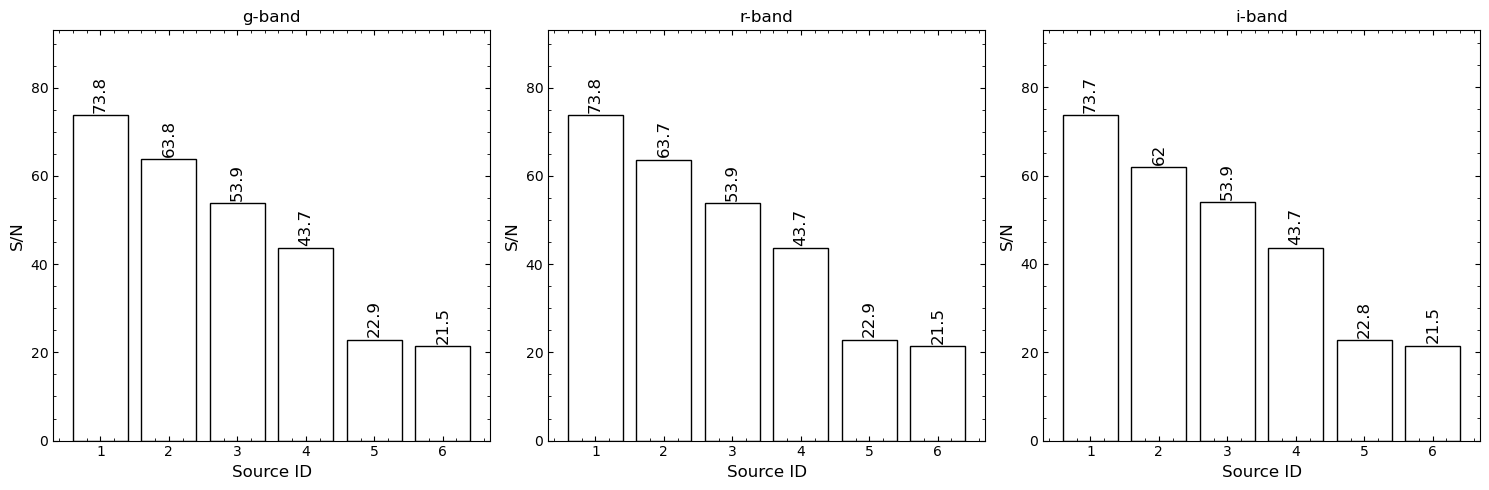

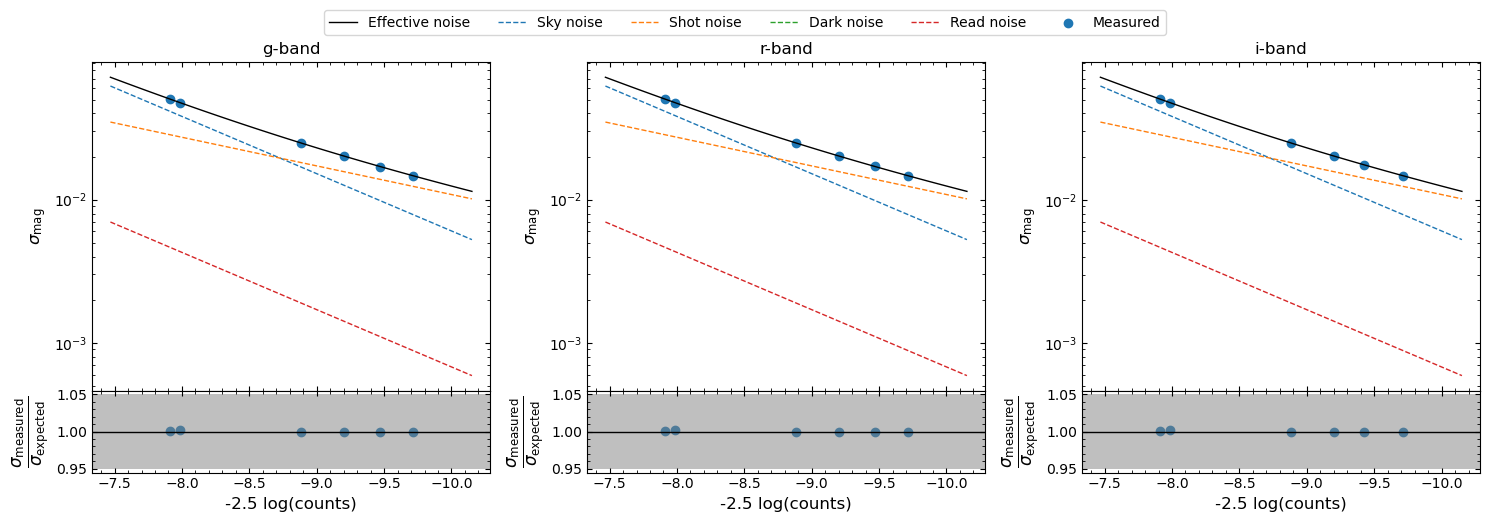

In [10]:
default_reducer = opticam.Reducer(
    out_directory='finders_tutorial/default_results',
    data_directory='finders_tutorial/data',
    remove_cosmic_rays=False,
)

default_reducer.create_catalogs()

Unsurprisingly, the default source finder has also identified all six sources. Admittedly, this rather simple example does a poor job of demonstrating why defining a custom source finder may be useful, but hopefully it is clear how custom source finders can be implemented. For more information on defining custom source finders, I again refer to the excellent `photutils` documentation: https://photutils.readthedocs.io/en/stable/user_guide/segmentation.html. Note that `opticam` requires that source finder routines return an `astropy.table.QTable` instance when called.

That concludes the source finder tutorial for `opticam`!